# CNN For Predicting Welding Quality

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import util
import numpy as np
from config import *
from cnn import Cnn
%matplotlib inline

## Prepare data

Data is a three-dimensional time series consisting of **electrode position, current, and voltage**

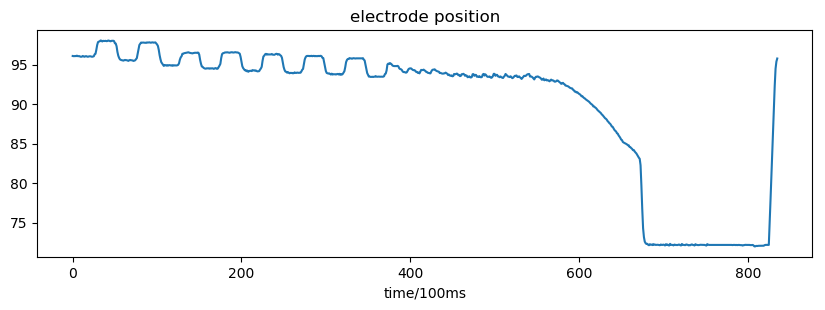

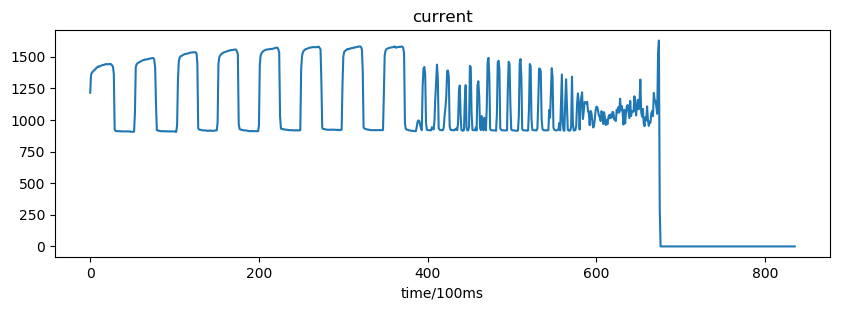

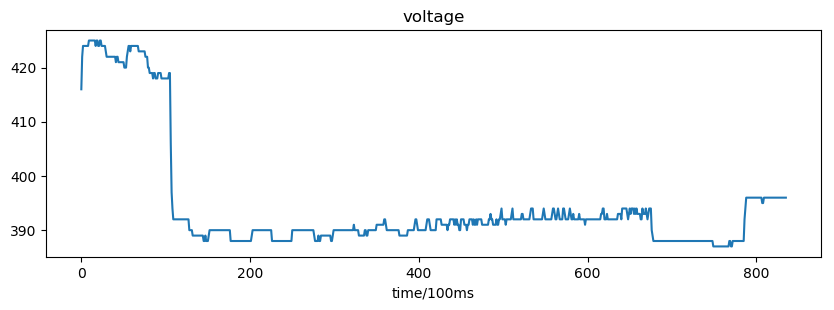

In [2]:
data, num1, num2 = util.load_data(False)
plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('electrode position')
plt.plot(data[0][:, 0])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('current')
plt.plot(data[0][:, 1])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('voltage')
plt.plot(data[0][:, 2])

plt.show()

We use downsampling to make the sequences equal in length. It can be seen that after downsampling to a length of 600, there is not much loss in the characteristics of the data.

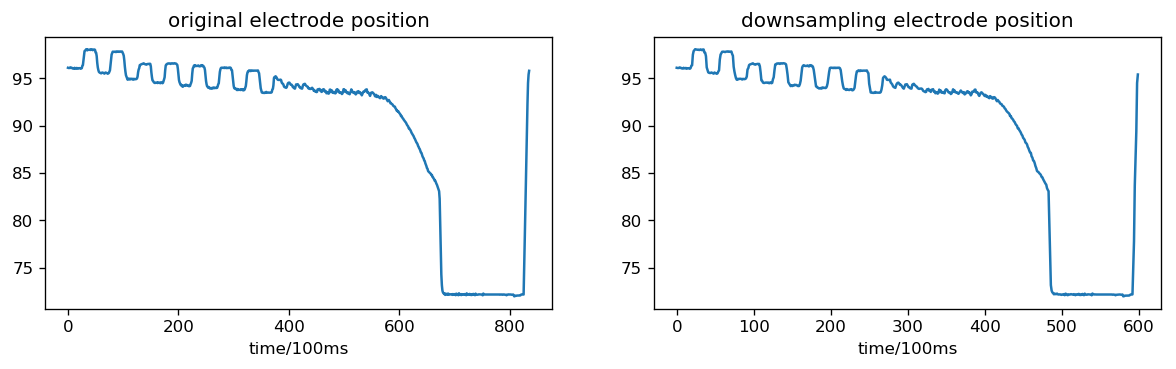

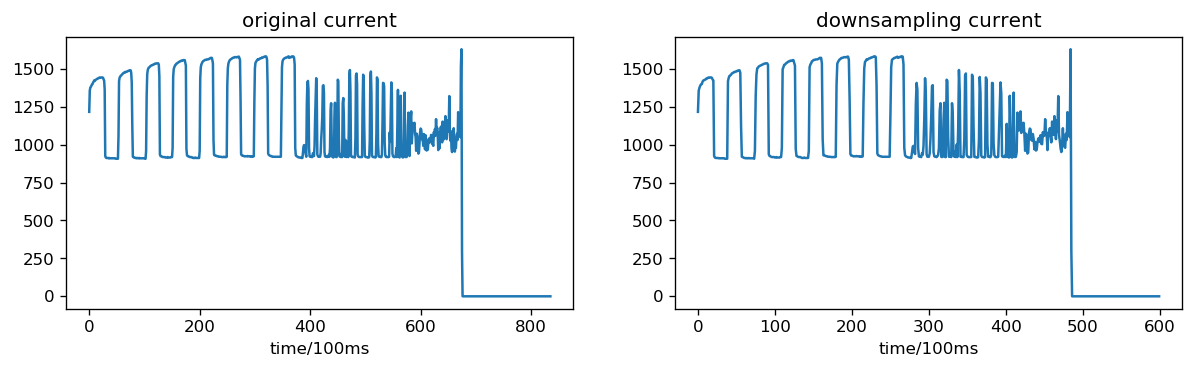

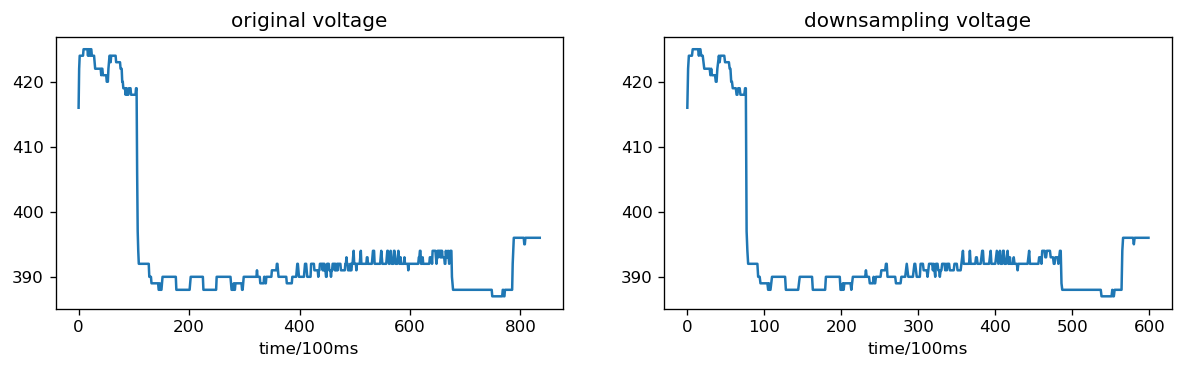

In [3]:
data2, length = util.resample(data, 600)
plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original electrode position')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 0])
plt.subplot(122)
plt.title('downsampling electrode position')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 0])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original current')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 1])
plt.subplot(122)
plt.title('downsampling current')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 1])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original voltage')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 2])
plt.subplot(122)
plt.title('downsampling voltage')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 2])

plt.show()

Since we only have 50 bad samples, we use transition and adding noise to expand the bad samples.    
  
First, adding noise means that add random number to each time of each dim of data. In my project, I use -0.5~0.5.

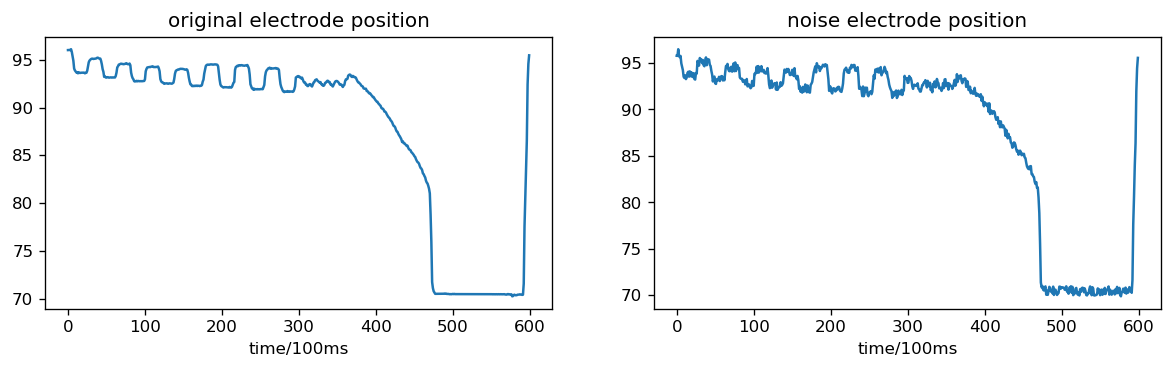

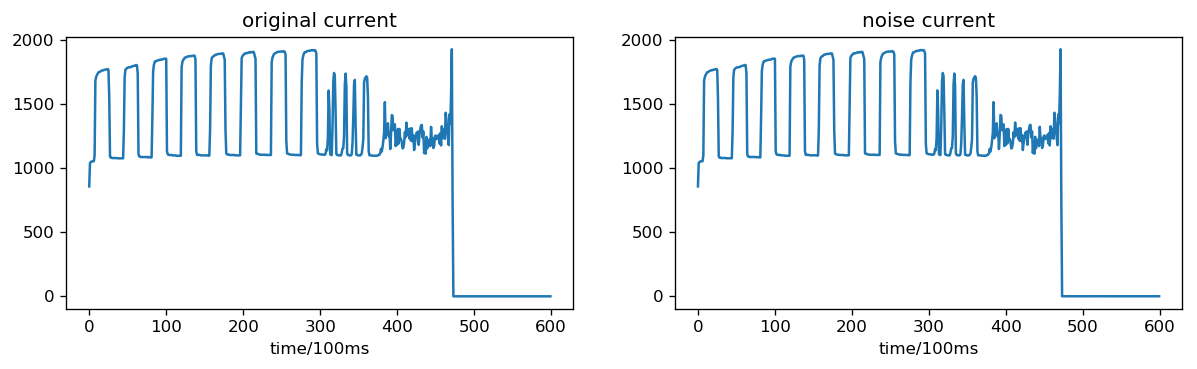

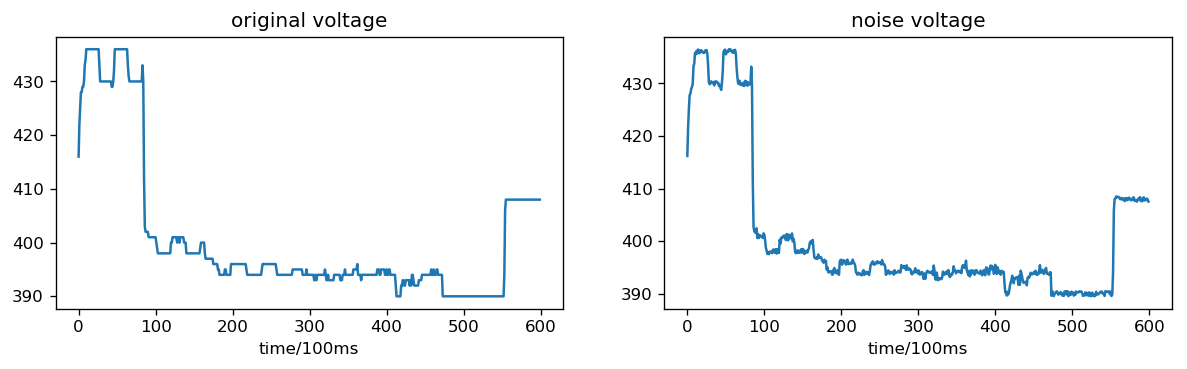

In [4]:
data, length = util.resample(data, 600)
data = util.reshape(data, length)
data_noise = util.add_noise(data[-1:], 1, 1)
plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original electrode position')
plt.xlabel('time/100ms')
plt.plot(data[-1][:, 0])
plt.subplot(122)
plt.title('noise electrode position')
plt.xlabel('time/100ms')
plt.plot(data_noise[0][:, 0])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original current')
plt.xlabel('time/100ms')
plt.plot(data[-1][:, 1])
plt.subplot(122)
plt.title('noise current')
plt.xlabel('time/100ms')
plt.plot(data_noise[0][:, 1])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original voltage')
plt.xlabel('time/100ms')
plt.plot(data[-1][:, 2])
plt.subplot(122)
plt.title('noise voltage')
plt.xlabel('time/100ms')
plt.plot(data_noise[0][:, 2])

plt.show()

Second, transtition means that make the data whole up or down. In my project, I use -1~1

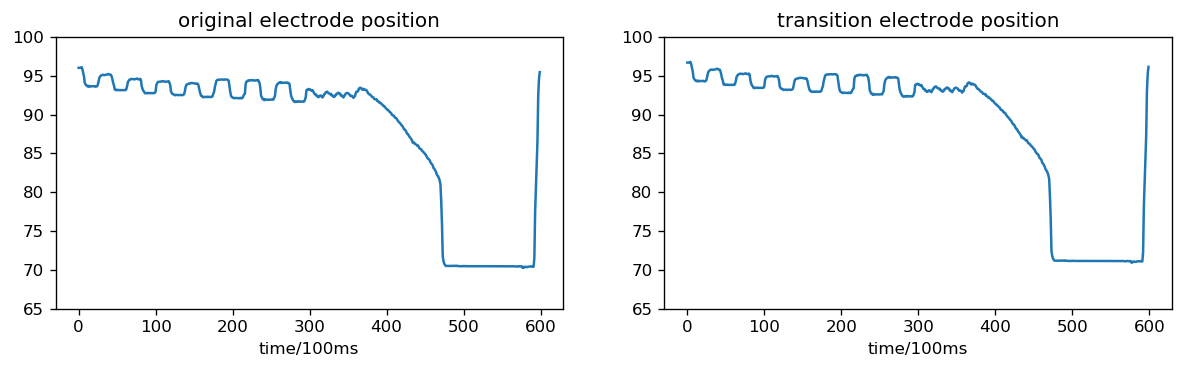

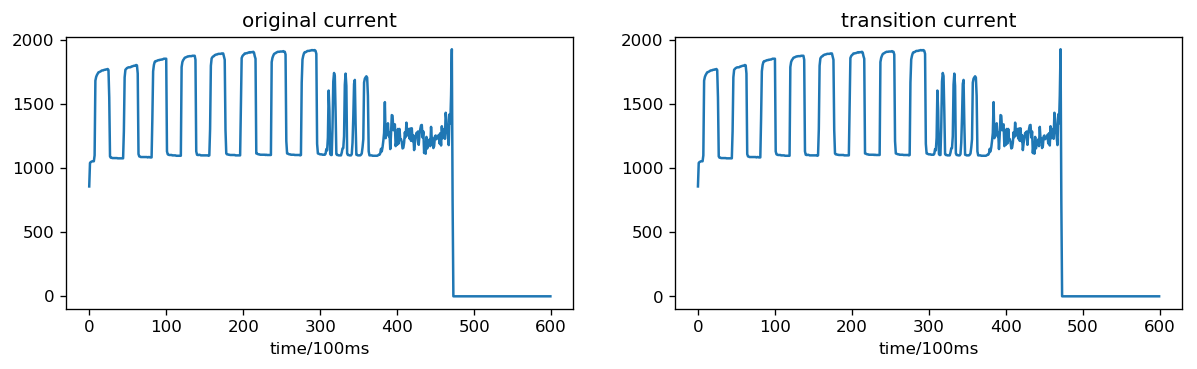

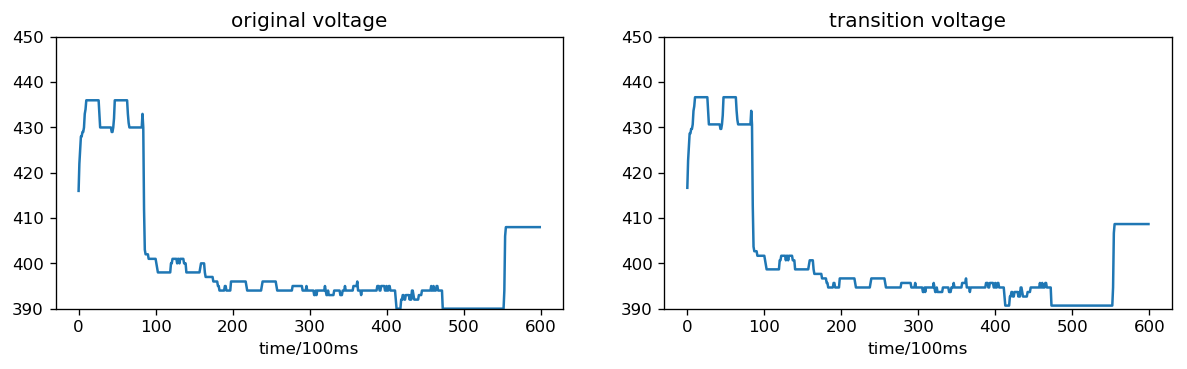

In [5]:
data, length = util.resample(data, 600)
data = util.reshape(data, length)
data_transition = util.transition(data[-1:], 1, 2)
plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original electrode position')
plt.xlabel('time/100ms')
plt.ylim(65, 100)
plt.plot(data[-1][:, 0])
plt.subplot(122)
plt.title('transition electrode position')
plt.xlabel('time/100ms')
plt.ylim(65, 100)
plt.plot(data_transition[0][:, 0])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original current')
plt.xlabel('time/100ms')
plt.plot(data[-1][:, 1])
plt.subplot(122)
plt.title('transition current')
plt.xlabel('time/100ms')
plt.plot(data_transition[0][:, 1])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original voltage')
plt.xlabel('time/100ms')
plt.ylim(390, 450)
plt.plot(data[-1][:, 2])
plt.subplot(122)
plt.title('transition voltage')
plt.xlabel('time/100ms')
plt.ylim(390, 450)
plt.plot(data_transition[0][:, 2])

plt.show()

Before starting data processing, **you must give some parameters that involved with loading data and preparing data**

In [6]:
# expand train data, the rest is transition
add_noise_radio = 0.5

# the number of data for train and test, must smaller than 2050
num_data = 1000

In [7]:
data, num_good, num_bad = util.load_data(num_data // 2)

# resample
data, length = util.resample(data, 600)
data = util.reshape(data, length)
good_data_origin = data[:num_good, :]
bad_data_origin = data[num_good:, :]

# extract bad data for test and train
permutation = list(np.random.permutation(len(bad_data_origin)))
shuffled_bad_data = bad_data_origin[permutation, :]
test_bad_data = shuffled_bad_data[:int(num_bad * 0.3), :]
train_bad_data_origin = shuffled_bad_data[int(num_bad * 0.3):, :]
# extract corresponding good data for test and train
permutation = list(np.random.permutation(len(good_data_origin)))
shuffled_good_data = good_data_origin[permutation, :]
test_good_data = shuffled_good_data[:len(test_bad_data), :]
train_good_data = shuffled_good_data[len(test_bad_data):, :]

# construct test data
test_y = np.array([1.] * len(test_good_data) + [0.] * len(test_bad_data), dtype=np.float).reshape((len(test_bad_data) + len(test_good_data), 1))
test_x = np.vstack((test_good_data, test_bad_data))

# expand the number of bad data for train
add_noise = int((len(train_good_data) - len(train_bad_data_origin)) * add_noise_radio)
transition = len(train_good_data) - add_noise - len(train_bad_data_origin)
if add_noise and transition:
    result1 = util.add_noise(train_bad_data_origin, add_noise, 1)
    result2 = util.transition(train_bad_data_origin, transition, 4)
    train_bad_data = np.vstack((result1, result2, train_bad_data_origin))
else:
    train_bad_data = train_bad_data_origin

assert len(train_bad_data) == len(train_good_data)
# construct train data
train_y = np.array([1.] * len(train_good_data) + [0.] * len(train_bad_data), dtype=np.float).reshape((len(train_bad_data) + len(train_good_data), 1))
train_x = np.vstack((train_good_data, train_bad_data))

# regularize
for i in range(len(train_x)):
    train_x[i, :, 0] = util.regularize(train_x[i, :, 0])
    train_x[i, :, 1] = util.regularize(train_x[i, :, 1])
    train_x[i, :, 2] = util.regularize(train_x[i, :, 2])
for i in range(len(test_x)):
    test_x[i, :, 0] = util.regularize(test_x[i, :, 0])
    test_x[i, :, 1] = util.regularize(test_x[i, :, 1])
    test_x[i, :, 2] = util.regularize(test_x[i, :, 2])

# random
train_x, train_y = util.shuffle_data(train_x, train_y)

# Hyperparameters

In [8]:
# numbers of neurons in each convolution layer, 0 is the max pool, -1 is the dropout
conv_layers = [18, 0, 36, 0, 72, -1, 0, 144]

# (filter size, step, pad) in filters in each layers. For pad, fill in 'SAME' or 'VALID'.
# Must correspond to conv_layers. If it is dropout, fill with 0
filters = [(2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), 0, (2, 2, 'SAME'),
           (2, 1, 'SAME')]

# the dims of full connected layers. The last layer is 1 and you do not need to write it on. Already implement dropout.
fc_layers = []

learning_rate = 0.00005

num_epochs = 100

# 0->disable
mini_batch_size = 64

# dropout
keep_prob = 0.3

## Construct CNN

In [9]:
graph = tf.Graph()

with graph.as_default():
    cnn = Cnn(conv_layers, fc_layers, filters, learning_rate)
    (m, n_W0, n_C0) = train_x.shape
    n_y = train_y.shape[1]
    
    cnn.initialize(n_W0, n_C0, n_y)
    cnn.forward()
    cost = cnn.cost()
    optimizer = cnn.get_optimizer(cost)
    predict, accuracy = cnn.predict()

## Train

In [10]:
# log the cost and accuracy
cost_log = []
test_log = []
train_log = []
x = []

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1, num_epochs + 1):
        if mini_batch_size != 0:
            num_mini_batches = int(m / mini_batch_size)
            mini_batches = util.random_mini_batches(train_x, train_y, mini_batch_size)

            cost_value = 0
            for mini_batch in mini_batches:
                (mini_batch_x, mini_batch_y) = mini_batch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={cnn.x: mini_batch_x, cnn.y: mini_batch_y, cnn.keep_prob: keep_prob})
                cost_value += temp_cost
            cost_value /= num_mini_batches
        else:
            _, cost_value = sess.run([optimizer, cost], feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: keep_prob})

        # disable dropout
        train_accuracy, output = sess.run([accuracy, predict], feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: 1})
        test_accuracy = sess.run(accuracy, feed_dict={cnn.x: test_x, cnn.y: test_y, cnn.keep_prob: 1})

        cost_log.append(cost_value)
        train_log.append(train_accuracy)
        test_log.append(test_accuracy)
        x.append(i)

        if print_detail and (i % 10 == 0 or i == 1):
            print('Iteration '+str(i))
            print('Cost: '+str(cost_value))
            print('Train accuracy: '+str(train_accuracy))
            print('Test accuracy: '+str(test_accuracy))
            print()

Iteration 1
Cost: 0.7263030807177225
Train accuracy: 0.5
Test accuracy: 0.5

Iteration 10
Cost: 0.17179300089677174
Train accuracy: 0.94536084
Test accuracy: 0.93333334

Iteration 20
Cost: 0.0980964740117391
Train accuracy: 0.9721649
Test accuracy: 0.96666664

Iteration 30
Cost: 0.06347303011765083
Train accuracy: 0.9762887
Test accuracy: 0.96666664

Iteration 40
Cost: 0.05382556356489658
Train accuracy: 0.97938144
Test accuracy: 0.96666664

Iteration 50
Cost: 0.04952905482302109
Train accuracy: 0.9824742
Test accuracy: 0.96666664

Iteration 60
Cost: 0.04111082218587399
Train accuracy: 0.9876289
Test accuracy: 0.96666664

Iteration 70
Cost: 0.03114211158826947
Train accuracy: 0.9896907
Test accuracy: 0.93333334

Iteration 80
Cost: 0.022287449178596336
Train accuracy: 0.9927835
Test accuracy: 0.93333334

Iteration 90
Cost: 0.023503226856701077
Train accuracy: 0.99072164
Test accuracy: 0.93333334

Iteration 100
Cost: 0.017122008713583152
Train accuracy: 0.9938144
Test accuracy: 0.9333333

## Chart

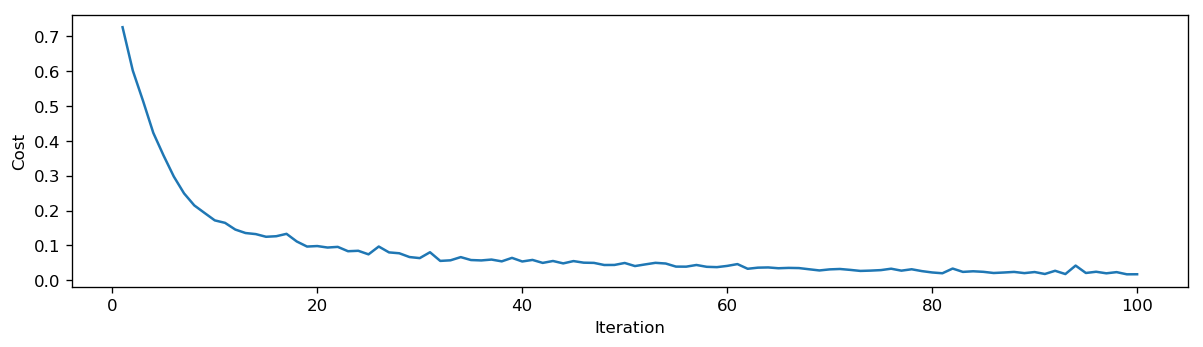

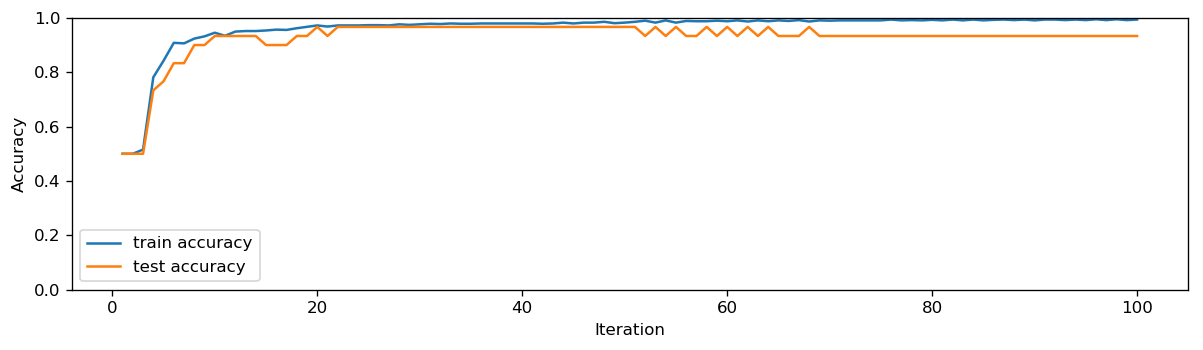

In [11]:
plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.plot(x, cost_log)

plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.plot(x, train_log, label='train accuracy')
plt.plot(x, test_log, label='test accuracy')
plt.legend()

plt.show()